# Baseline-sample

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa

import transformers
from transformers import AutoTokenizer
transformers.logging.set_verbosity_error()

import re
from tqdm import tqdm

import argparse
import wandb
from wandb.keras import WandbCallback
wandb.init(project="DACON_235900", name="Baseline-sample")

parser = argparse.ArgumentParser(description='Baseline')
parser.add_argument('--pretrained_model', default="codebert", type=str)
parser.add_argument('--max_length', default=256, type=int)
parser.add_argument('--optimizer', default="sgd", type=str) # sgd or adam
parser.add_argument('--learning_rate', default=0.01, type=float)
parser.add_argument('--batch_size', default=32, type=int)
parser.add_argument('--epochs', default=100, type=int)
parser.add_argument('--validation_split', default=0.2, type=float)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

wandb.config.update(args)

if args.pretrained_model == "bert":
    pretrained_model = "bert-base-uncased"
elif args.pretrained_model == "codebert":
    pretrained_model = "microsoft/graphcodebert-base"
    
tokenizer = AutoTokenizer.from_pretrained(pretrained_model, do_lower_case=True)
tokenizer.truncation_side='left'

MAX_LENGTH = args.max_length
BATCH_SIZE=args.batch_size
EPOCHS=args.epochs
VALIDATION_SPLIT=args.validation_split
SEED=args.seed

def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds()

wandb: Currently logged in as: gnoeyheat (use `wandb login --relogin` to force relogin)


## Preprocessing

In [2]:
train = pd.read_csv("data/sample_train.csv")
test = pd.read_csv("data/test.csv")

train.shape, test.shape

((17970, 3), (179700, 3))

In [3]:
train["similar"].value_counts()

1    9005
0    8965
Name: similar, dtype: int64

In [4]:
def text_preprocessing(series):
    temp = series.copy()
    temp = temp.apply(lambda x : re.sub(re.compile("\"\"\".*\"\"\"", re.DOTALL), "", x))
    temp = temp.apply(lambda x : re.sub(re.compile("\'\'\'.*\'\'\'", re.DOTALL), "", x))
    temp = temp.apply(lambda x : re.sub(re.compile("#.*"), "", x))
    temp = temp.apply(lambda x : re.sub("print(.*)", "", x))
    temp = temp.apply(lambda x : x.replace("    ","\t"))
    temp = temp.apply(lambda x : x.split("\n"))
    temp_document=[]
    for document in tqdm(temp):
        temp_sentence=[]
        for sentence in document:
            if "import" in sentence:
                continue
            if sentence=="":
                continue
            temp_sentence.append(sentence.rstrip())
        temp_document.append("\n".join(temp_sentence))
    temp = pd.Series(data=temp_document, index=temp.index, name=temp.name)
    return temp

def data_preprocessing(df, mode):
    temp = df.copy()
    temp["code1"] = text_preprocessing(temp["code1"])
    temp["code2"] = text_preprocessing(temp["code2"])
    temp["len1"] = temp["code1"].apply(tokenizer.tokenize).apply(len)
    temp["len2"] = temp["code2"].apply(tokenizer.tokenize).apply(len)
    if mode=="train":
        temp = temp[(temp['len1']<=MAX_LENGTH)&
                    (temp['len2']<=MAX_LENGTH)].reset_index(drop=True)
    return temp

In [5]:
train = data_preprocessing(train, "train")
test = data_preprocessing(test, "test")

train.head()

100%|██████████████████████████████████████████████████████████████████████| 179700/179700 [00:00<00:00, 268549.99it/s]


,code1,code2,similar,len1,len2
0,"flag = ""go""\ncnt = 0\nwhile flag == ""go"":\n\tc...",ff = sys.stdin\ncnt = 1\nfor line in ff :\n\ti...,1,51,34
1,"b, c = map(int, input().split())","n = int(input())\na = np.array(list(map(int,in...",0,12,34
2,"b, c = map(int, input().split())","n,m=map(int,input().split())\nh=list(map(int,i...",0,12,129
3,s=input()\nt=input()\nans=0\nfor i in range(le...,"a,b,h,m=map(int,input().split())\nlrad=6*m\nsr...",0,42,89
4,"n,m = map(int,input().split())\nl=1\nif n%2==1...","N = int(input())\nL = list(map(int, input().sp...",0,179,155


## Modelling

In [6]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    
    def __init__(
        self,
        sentence_pairs,
        labels=[0, 1],
        batch_size=BATCH_SIZE,
        shuffle=True,
        include_targets=True,
    ):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        self.tokenizer = tokenizer
        self.indexes = np.arange(len(self.sentence_pairs))
        self.on_epoch_end()

    def __len__(self):
        return len(self.sentence_pairs) // self.batch_size

    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        sentence_pairs = self.sentence_pairs[indexes]

        encoded = self.tokenizer.batch_encode_plus(
            sentence_pairs.tolist(),
            add_special_tokens=True,
            padding="max_length",
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors="tf",
            return_token_type_ids=True,
            return_attention_mask=True,
        )

        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")

        if self.include_targets:
            labels = np.array(self.labels[indexes], dtype="int32")
            return [input_ids, attention_masks, token_type_ids], labels
        else:
            return [input_ids, attention_masks, token_type_ids]

    def on_epoch_end(self):
        if self.shuffle:
            np.random.RandomState(SEED).shuffle(self.indexes)

In [7]:
input_ids = tf.keras.layers.Input(
    shape=(MAX_LENGTH,), dtype=tf.int32, name="input_ids"
)
attention_masks = tf.keras.layers.Input(
    shape=(MAX_LENGTH,), dtype=tf.int32, name="attention_masks"
)
token_type_ids = tf.keras.layers.Input(
    shape=(MAX_LENGTH,), dtype=tf.int32, name="token_type_ids"
)

bert_model = transformers.TFAutoModel.from_pretrained(pretrained_model)
bert_model.trainable = False

bert_output = bert_model(
    input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids
)

sequence_output = bert_output.last_hidden_state
pooled_output = bert_output.pooler_output

bi_lstm = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64, return_sequences=True)
)(sequence_output)

avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
concat = tf.keras.layers.concatenate([avg_pool, max_pool])
dropout = tf.keras.layers.Dropout(0.3)(concat)
output = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)
                                                        
model = tf.keras.models.Model(
    inputs=[input_ids, attention_masks, token_type_ids], outputs=output
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_ids[0][0]',              
 el)                            thPoolingAndCrossAt               'attention_masks[0][0]',    

## Training

In [8]:
X = train[["code1", "code2"]]
y = train["similar"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VALIDATION_SPLIT, random_state=SEED, stratify=y)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((10971, 2), (2743, 2), (10971,), (2743,))

In [9]:
train_data = BertSemanticDataGenerator(
    X_train[["code1", "code2"]].values,
    y_train.values,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
valid_data = BertSemanticDataGenerator(
    X_val[["code1", "code2"]].values,
    y_val.values,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [10]:
lr = tf.keras.optimizers.schedules.CosineDecay(args.learning_rate, decay_steps=1000)
if args.optimizer == "sgd":
    optim = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
elif args.optimizer == "adam":
    optim = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(
    optimizer=optim,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

checkpoint_filepath=f"load_model/{parser.description}"

callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )
]


history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS,
    callbacks=[callback, WandbCallback()],
)

Epoch 1/100
342/342 [==============================] - 92s 242ms/step - loss: 0.6691 - accuracy: 0.5817 - val_loss: 0.6179 - val_accuracy: 0.7103 - _timestamp: 1654084861.0000 - _runtime: 249.0000
Epoch 2/100
342/342 [==============================] - 80s 233ms/step - loss: 0.5926 - accuracy: 0.6839 - val_loss: 0.5535 - val_accuracy: 0.7298 - _timestamp: 1654084940.0000 - _runtime: 328.0000
Epoch 3/100
342/342 [==============================] - 80s 235ms/step - loss: 0.5344 - accuracy: 0.7396 - val_loss: 0.5005 - val_accuracy: 0.7827 - _timestamp: 1654085021.0000 - _runtime: 409.0000
Epoch 4/100
342/342 [==============================] - 76s 223ms/step - loss: 0.5250 - accuracy: 0.7460 - val_loss: 0.5005 - val_accuracy: 0.7827 - _timestamp: 1654085099.0000 - _runtime: 487.0000
Epoch 5/100
342/342 [==============================] - 76s 223ms/step - loss: 0.5263 - accuracy: 0.7457 - val_loss: 0.5005 - val_accuracy: 0.7827 - _timestamp: 1654085175.0000 - _runtime: 563.0000
Epoch 6/100
342

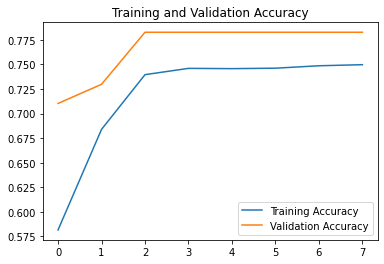

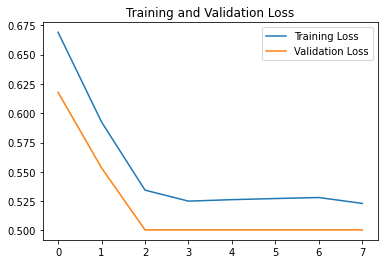

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
model.load_weights(checkpoint_filepath)

### Fine Tuning

In [13]:
bert_model.trainable = True

lr = tf.keras.optimizers.schedules.CosineDecay(args.learning_rate*0.1, decay_steps=1000)
if args.optimizer == "sgd":
    optim = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
elif args.optimizer == "adam":
    optim = tf.keras.optimizers.Adam(learning_rate=lr)

model.compile(
    optimizer=optim,
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

checkpoint_filepath=f"load_model/{parser.description}"

callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    ),
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )
]

history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=EPOCHS,
    callbacks=[callback, WandbCallback()],
)

Epoch 1/100
342/342 [==============================] - 182s 497ms/step - loss: 0.4034 - accuracy: 0.8126 - val_loss: 0.2291 - val_accuracy: 0.9110 - _timestamp: 1654085585.0000 - _runtime: 973.0000
Epoch 2/100
342/342 [==============================] - 165s 484ms/step - loss: 0.2417 - accuracy: 0.9030 - val_loss: 0.1955 - val_accuracy: 0.9246 - _timestamp: 1654085751.0000 - _runtime: 1139.0000
Epoch 3/100
342/342 [==============================] - 166s 486ms/step - loss: 0.1880 - accuracy: 0.9274 - val_loss: 0.1921 - val_accuracy: 0.9246 - _timestamp: 1654085916.0000 - _runtime: 1304.0000
Epoch 4/100
342/342 [==============================] - 157s 459ms/step - loss: 0.1748 - accuracy: 0.9327 - val_loss: 0.1921 - val_accuracy: 0.9246 - _timestamp: 1654086076.0000 - _runtime: 1464.0000
Epoch 5/100
342/342 [==============================] - 157s 460ms/step - loss: 0.1769 - accuracy: 0.9313 - val_loss: 0.1921 - val_accuracy: 0.9246 - _timestamp: 1654086233.0000 - _runtime: 1621.0000
Epoch 

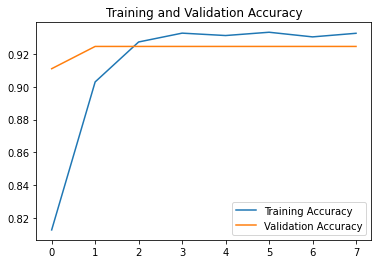

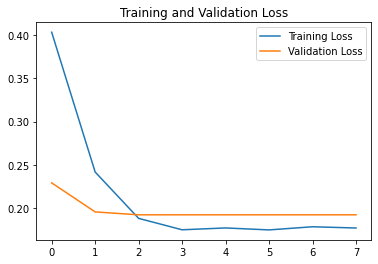

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
model.load_weights(checkpoint_filepath)

## Inference

In [16]:
test_data = BertSemanticDataGenerator(
    test[["code1", "code2"]].values,
    None,
    batch_size=BATCH_SIZE,
    shuffle=False,
    include_targets=False,
)

In [17]:
preds=[]
for i in tqdm(range((len(test)//BATCH_SIZE)+1)):
    temp = test_data[i]
    preds.append(model.predict(temp))
preds=np.vstack(preds)

preds.shape

100%|██████████████████████████████████████████████████████████████████████████████| 5616/5616 [17:31<00:00,  5.34it/s]


(179700, 1)

In [18]:
submission = pd.read_csv("data/sample_submission.csv")
submission['similar'] = np.where(preds>0.5, 1, 0)
submission.to_csv(f"{parser.description}.csv", index=False)